# Comparison Between Methods

### In this notebook, 


In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import os
sys.path.append(os.path.abspath("../../"))  # or "." or ".." depending on your structure

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations, params
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator_finalVersion import BCUC_Calibrator
from models.model_utils import params
from calibrator_module.nll_threshold_calibrator import NLLThresholdCalibrator
from calibrator_module.direct_Q_calibrator import DirectQCalibrator
from calibrator_module.NLL_gradient_descent_calibrator import NLLBasedQCalibrator
from calibrator_module.conformal_prediction_classic import conformalPrediction_Calibrator

In [39]:

!python ../observation_generation.py --dir_path "../observations" --format npz --n_steps 10000

4732.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Creating linear system...
[[0.3]]

Generating observations for random_zeros_and_actions actions...
Generated 10001 observations
Observation shape: (1,)
Data saved as ../observations/observations_random_zeros_and_actions_for_Q0.3_steps_10000.npz
Model parameters saved as ../observations/observations_random_zeros_and_actions_for_Q0.3_steps_10000_params.json
Observation mean: [4.85750018]
Observation std: [1.76903086]
Observation generation complete!

Recommended workflow:
1. Use .npz format for numerical analysis in Python
2. Use .csv format for analysis in Excel or pandas
3. Use .json format for human-readable debugging
4. Use .mat format for MATLAB interoperability


In [ ]:
# --- Load data ---
from models.model_utils import params
persons = [0.01, 0.3, 0.7, 1.5]
initial_model = LinearModel_Estimator(**params)
print(f"Initial Q matrix: {initial_model.Q}")


calibrators_BCUC = []
calibrators_conformalPred = []
calibrators_nll = []

calibrated_models_BCUC = []
calibrated_models_conformalPred = []
calibrated_models_nll = []

metrics_BCUC = []
metrics_conformalPred = []
metrics_nll = []

# --
for person in persons:
    path_to_load = f"../../observations/observations_random_zeros_and_actions_for_Q{person}_steps_10000.npz"
    data = np.load(path_to_load, allow_pickle=True)
    masked_observations = mask_observations(data['observations'])
    actions = data['actions']

    # --- build models ---
    to_print = f"Target (true) Q*: {person}"
    print(to_print)
    
    cal_qc = BCUC_Calibrator(
        initial_model=initial_model,
        alpha=0.32,          # μ±σ target; keeps Q identification unbiased if Gaussian
    )
    model_qc = cal_qc.calibrate_model(masked_observations, actions)
    calibrated_models_BCUC.append(model_qc)
    calibrators_BCUC.append(cal_qc)

    cal_cp = conformalPrediction_Calibrator(
    initial_model=initial_model,
    update_after_every=15
    )
    
    model_cp = cal_cp.calibrate_model(masked_observations, actions)
    calibrated_models_conformalPred.append(model_cp)
    calibrators_conformalPred.append(cal_cp)

    cal_nll = NLLBasedQCalibrator(
    initial_model=initial_model,
    update_after_every=15
    )
    
    model_nll = cal_nll.calibrate_model(masked_observations, actions)
    calibrated_models_conformalPred.append(model_nll)
    calibrators_nll.append(cal_nll)
    
    NLLBasedQCalibrator
    # --- evaluate metrics ---
    metrics_qc = cal_qc.get_metrics(person)
    metrics_BCUC.append(metrics_qc)
    metrics_cp = cal_cp.get_metrics(person)
    metrics_conformalPred.append(metrics_cp)
    metrics_nll_dict = cal_nll.get_metrics(person)
    metrics_nll.append(metrics_nll_dict)
    
    # --- print results ---
    print("[BCUC quantile_coupled]")
    print("metrics:", metrics_qc)
    print("final Q:", model_qc.Q)
    print()
    print("[Conformal Prediction quantile_coupled Threshold Calibrator]")
    print("metrics:", metrics_cp)
    print("final Q:", model_cp.Q)
    print()
    print("[NLL Based Q Calibrator]")
    print("metrics:", metrics_nll_dict)
    print("final Q:", model_nll.Q)
    print()

Initial Q matrix: [[0.6275]]
Target (true) Q*: 0.01
[BCUC quantile_coupled]
metrics: {'E_bar': 0.28554979850316636, 'coverage': 0.7144502014968337, 'mean_interval_width': 0.3351726108909286, 'avg_nll': -0.9813455934013139, 'final_difference': 0.014743392780994844, 'relative_error': 1.4743392780994844}
final Q: [[0.02474339]]

[Conformal Prediction quantile_coupled Threshold Calibrator]
metrics: {'E_bar': 0.5372769142199194, 'coverage': 0.4627230857800806, 'mean_interval_width': 0.23417284609269337, 'avg_nll': -1.269300151057989, 'final_difference': 0.0014279868392486801, 'relative_error': 0.142798683924868}
final Q: [[0.00857201]]

[NLL Based Q Calibrator]
metrics: {'E_bar': 0.0012953367875647714, 'coverage': 0.9987046632124352, 'mean_interval_width': 0.3533854858359815, 'avg_nll': -0.851649895836008, 'final_difference': 0.06371623015568616, 'relative_error': 6.371623015568615}
final Q: [[0.07371623]]

Target (true) Q*: 0.3
[BCUC quantile_coupled]
metrics: {'E_bar': 0.31332757628094415

In [28]:
Q_vals_BCUC = [cal.Q_history for cal in calibrators_BCUC]
Q_vals_conformal= [cal.Q_history for cal in calibrators_conformalPred]
Q_vals_nll= [cal.Q_history for cal in calibrators_nll]

q_vals_BCUC = [cal.q_history for cal in calibrators_BCUC]
q_vals_conformal = [cal.q_history for cal in calibrators_conformalPred]
# q_vals_qf = cal_qf.q_history #should be 1 always - just for sanity check

# interval_widths_BCUC = [cal.interval_widths for cal in calibrators_BCUC]
# interval_widths_conformal = [cal.interval_widths for cal in calibrated_models_conformalPred]

# # E = [cal.conformal_p_control.E for cal in calibrators]
# # E.append(calibrators[-1].E)
# # # E_qf = cal_qf.conformal_p_control.E
# # # E_null = [1 - h for h in cal_nll.coverage_hits]

# interval_widths_with_correction_BCUC = [val*q for val, q in zip(interval_widths_BCUC, q_vals_BCUC)]
# interval_widths_with_correction_conformal = [val*q for val, q in zip(interval_widths_conformal, q_vals_conformal)]
# sigma_BCUC = [[std/2 for std in interval_widths_with_correction_BCUC_p] for interval_widths_with_correction_BCUC_p in interval_widths_with_correction_BCUC] #this is the vlaues of the std but calculated right after the prediction 
# # #step (without the update step in case of observation available)
# # #it is necessary to follow this value to evaluate our calibration mechanism (we can check the interval width and cover precision)
# # sigma_qf = [std/2 for std in interval_widths_qf]
# # sigma_null = [std/2 for std in interval_widths_nll]

# meu = [[dictionary['mean'].flatten() for dictionary in model.dist_estimates] for model in calibrated_models]
# std = [[np.sqrt(dictionary['var'].flatten()) for dictionary in model.dist_estimates] for model in calibrated_models]
# meu = [np.array(meu).squeeze() for meu in meu]
# std = [np.array(std).squeeze() for std in std]

# meu_qf = [dictionary['mean'].flatten() for dictionary in model_qf.dist_estimates]
# std_qf = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_qf.dist_estimates]
# meu_qf = np.array(meu_qf[1:]).squeeze()   
# std_qf = np.array(std_qf[1:]).squeeze()

# meu_nll = [dictionary['mean'].flatten() for dictionary in model_nll.dist_estimates]
# std_nll = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_nll.dist_estimates]
# meu_nll = np.array(meu_nll[1:]).squeeze()   
# std_nll = np.array(std_nll[1:]).squeeze()

AttributeError: 'NLLBasedQCalibrator' object has no attribute 'q_history'

In [14]:
dir_name = "plots/all_together"
os.makedirs(dir_name, exist_ok=True)

## Plots

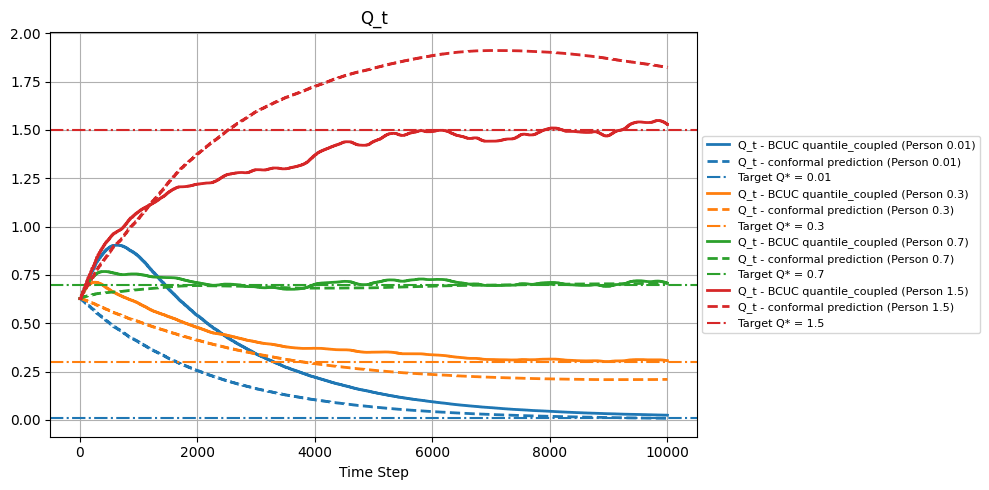

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Time Step")
ax.set_title("Q_t")
ax.grid(True)

for i, (Q_val, Q_val_conformal) in enumerate(zip(Q_vals_BCUC, Q_vals_conformal)):
    y = [q[0] for q in Q_val]
    y2 = [q[0] for q in Q_val_conformal]
    x = np.arange(len(y))
    line, = ax.plot(x, y, linewidth=2,
                    label=f"Q_t - BCUC quantile_coupled (Person {persons[i]})")
    
    color = line.get_color()
    line, = ax.plot(x, y2, linewidth=2,
                    label=f"Q_t - conformal prediction (Person {persons[i]})", color = color, linestyle='--')
    ax.axhline(y=persons[i], color=color, linestyle='-.',
               label=f"Target Q* = {persons[i]}")


# for i, Q_val in enumerate(Q_vals_nll[:2]):
#     y = [q[0] for q in Q_val]
#     x = np.arange(len(y))
#     line, = ax.plot(x, y, linewidth=2,
#                     label=f"Q_t - conformal prediction (Person {persons[i]})", color = color[i], linestyle='--')
#     # color = line.get_color()
  
# Legend outside
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

fig.tight_layout()
fig.savefig(os.path.join(dir_name, "Q_t_over_time.png"),
            dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(interval_widths_with_correction_qc, label="Prediction Interval Width - BCUC quantile_coupled", color='blue', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.title("Prediction Interval Width Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
fig_name = "plot_interval_width.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

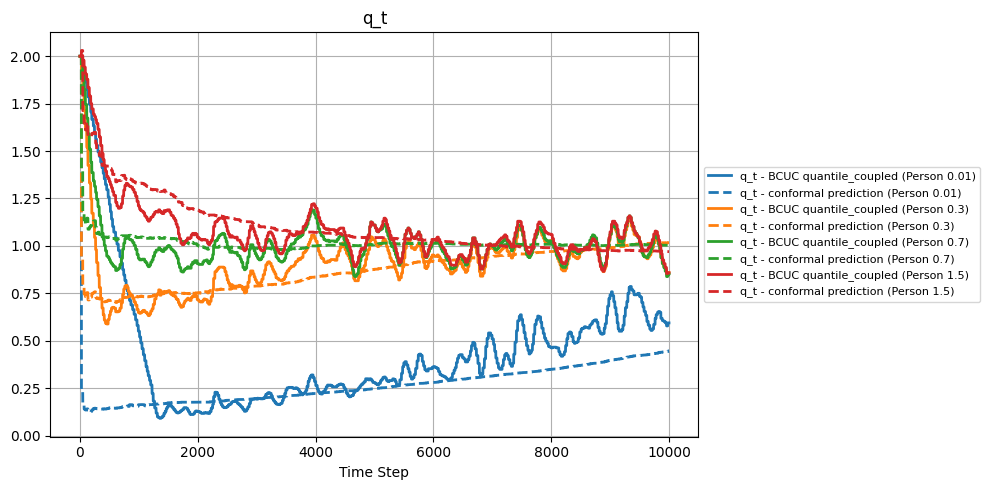

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Time Step")
ax.set_title("q_t")
ax.grid(True)

def to_1d_float(seq):
    # Coerce each entry to a scalar float; handles 1x1 arrays, lists, etc.
    return np.array([float(np.asarray(v).reshape(-1)[0]) for v in seq], dtype=float)

for i, (q_val, q_val_conformal) in enumerate(zip(q_vals_BCUC, q_vals_conformal)):
    y  = to_1d_float(q_val)
    y2 = to_1d_float(q_val_conformal)

    # If lengths differ, align to the shorter to avoid shape errors
    T = min(len(y), len(y2))
    x = np.arange(T)

    line, = ax.plot(x, y[:T], linewidth=2,
                    label=f"q_t - BCUC quantile_coupled (Person {persons[i]})")
    color = line.get_color()

    ax.plot(x, y2[:T], linewidth=2,
            label=f"q_t - conformal prediction (Person {persons[i]})",
            color=color, linestyle='--')

# Legend outside
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

fig.tight_layout()
fig.savefig(os.path.join(dir_name, "q_t_over_time.png"), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
ts = np.arange(len(meu)) 
plt.plot(ts, meu, label=" meu")
# plt.fill_between(ts, meu- std, meu + std, alpha=0.2, label="Confidence Interval")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation Over Time vs Observations")
plt.grid(True)
plt.tight_layout()
plt.savefig("calibrated_distribution_over_time_vs_observation.png", dpi=300)
plt.fill_between(ts, meu - sigma, meu + sigma, alpha=0.2, label="Confidence Interval")
ts_new = np.arange(np.size(masked_observations))
# mask = ~np.isnan(masked_observations)
# ts_valid = ts_new[mask.flatten()]
# obs_valid = masked_observations[mask.flatten()]
# plt.scatter(ts_valid, obs_valid, color='red', label='Observations')
obs = data['observations']
plt.scatter(ts_new, obs, color='red', label='Observations')
plt.show()


In [ ]:
mask = ~np.isnan(masked_observations)
obs_valid = masked_observations[mask.flatten()]
obs_valid.size

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(ts_new, within_band, color='red', label='Observations')
plt.show()



In [ ]:
within_band.size

In [ ]:
np.arange(np.size(masked_observations))

In [ ]:
# FOR DIFFERENT NOTEBOOK - COMPARISON BETWEEN METHODS

# # NLL method (no quantile)
# cal_nll = NLLGD_Calibrator(initial_model=patient_1_model, eta_Q=1e-2, clip_grad=1.0, ema_beta=0.9)
# model_nll = cal_nll.calibrate_model(masked_observations, actions)
# print("NLLGD metrics:", cal_nll.get_metrics())

# # Your B-CUC variants already return the same keys via get_metrics()
# cal_bcuc_qc = BCUC_Calibrator(patient_1_model, mode="quantile_coupled")
# cal_bcuc_qc.calibrate_model(masked_observations, actions)
# print("BCUC (quantile_coupled):", cal_bcuc_qc.get_metrics())

# cal_bcuc_qf = BCUC_Calibrator(patient_1_model, mode="quantile_free")
# cal_bcuc_qf.calibrate_model(masked_observations, actions)
# print("BCUC (quantile_free):", cal_bcuc_qf.get_metrics())